In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import describe

# Set up plotting style
plt.style.use('ggplot')

# Display settings
pd.set_option('display.float_format', '{:.6f}'.format)

In [ ]:
# $ python dl.py BTCUSDT 2024-11-01 2024-12-01 market_data binance 5m futures --type=um
# $ python dl.py BTCUSDT 2024-11-01 2024-12-01 market_data binance 5m spot

### <span style="color:red">Load Data</span>

In [2]:
# Load spot and perpetual futures price data
spot_data = pd.read_csv('market_data/binance-spot-BTCUSDT-5m.csv', index_col='time')
futures_data = pd.read_csv('market_data/binance-futures-BTCUSDT-5m.csv', index_col='time')
futures_data.index = pd.to_datetime(futures_data.index, unit='ms')
spot_data.index = pd.to_datetime(spot_data.index, unit='ms')

# Merge the datasets
data = pd.merge(spot_data['close'], futures_data['close'], 
                left_index=True, right_index=True, suffixes=('_spot', '_futures'))

data = data.dropna()
data.columns = ['spot', 'futures']

# Compute basis
data['basis'] = ((data['futures'] - data['spot']) / data['spot']) * 10e4

# Display the first few rows
data.head()


,spot,futures,basis
time,,,
2024-11-01 00:00:00,70349.670000,70378.200000,40.554561
2024-11-01 00:05:00,70382.000000,70408.100000,37.083345
2024-11-01 00:10:00,70461.990000,70481.700000,27.972528
2024-11-01 00:15:00,70453.750000,70484.500000,43.645654
2024-11-01 00:20:00,70398.960000,70424.300000,35.994850


### <span style="color:red">Exploratory Analysis</span>

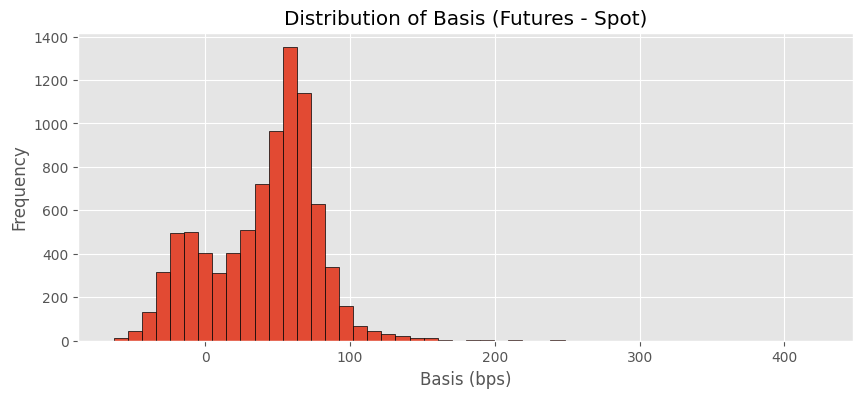

Basis Statistics:


count   8640.000000
mean      40.217967
std       37.971352
min      -63.163974
25%       13.074166
50%       49.068184
75%       65.550832
max      423.297181
Name: basis, dtype: float64

In [3]:
# Plot the distribution of basis
plt.figure(figsize=(10, 4))
plt.hist(data['basis'], bins=50, edgecolor='k')
plt.title('Distribution of Basis (Futures - Spot)')
plt.xlabel('Basis (bps)')
plt.ylabel('Frequency')
plt.show()

# Statistical description
print('Basis Statistics:')
data['basis'].describe()

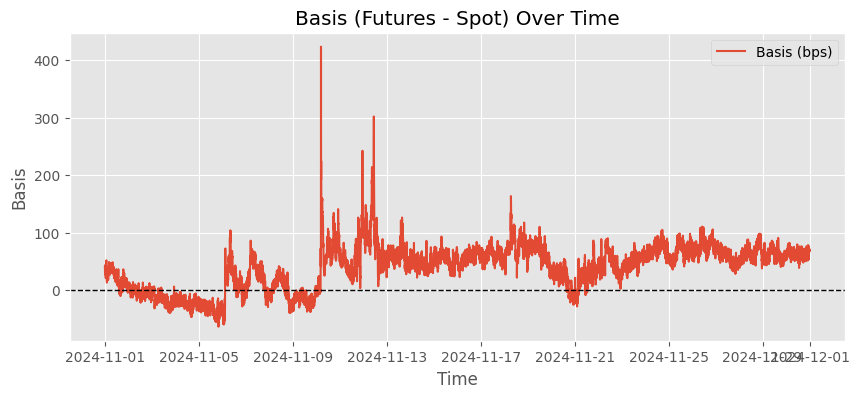

In [4]:
# Plot basis over time
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['basis'], label='Basis (bps)')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.title('Basis (Futures - Spot) Over Time')
plt.xlabel('Time')
plt.ylabel('Basis')
plt.legend()
plt.show()

### <span style="color:red">Arbitrage Opportunity Detection</span>

Number of Arbitrage Opportunities: 235


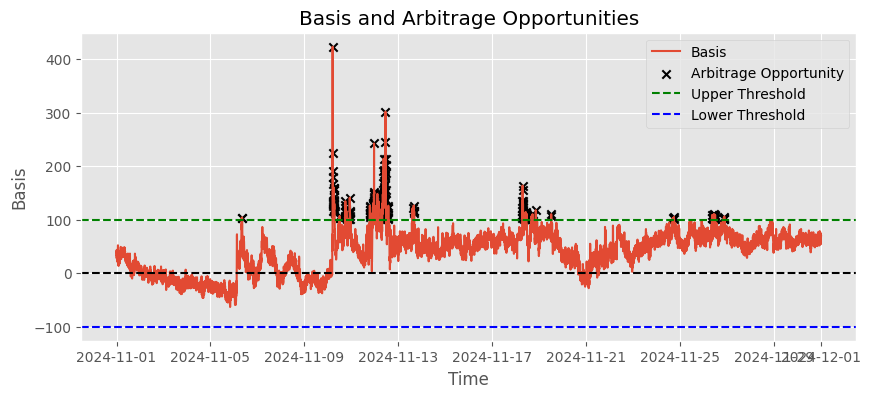

In [5]:
# Define arbitrage thresholds
threshold = 100 # 1% threshold (appx fees + slippage)

# Identify arbitrage opportunities
data['arbitrage_long'] = data['basis'] > threshold
data['arbitrage_short'] = data['basis'] < -threshold

# Arbitrage summary
arbitrage_opportunities = data[(data['arbitrage_long']) | (data['arbitrage_short'])]
print(f"Number of Arbitrage Opportunities: {len(arbitrage_opportunities)}")

# Plot basis with arbitrage points highlighted
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['basis'], label='Basis')
plt.scatter(arbitrage_opportunities.index, arbitrage_opportunities['basis'], 
            color='black', label='Arbitrage Opportunity', marker='x')
plt.axhline(threshold, color='green', linestyle='--', label='Upper Threshold')
plt.axhline(-threshold, color='blue', linestyle='--', label='Lower Threshold')
plt.axhline(0, color='black', linestyle='--')
plt.title('Basis and Arbitrage Opportunities')
plt.xlabel('Time')
plt.ylabel('Basis')
plt.legend()
plt.show()


In [6]:
# Calculate number of arbitrage signals
num_long = data['arbitrage_long'].sum()
num_short = data['arbitrage_short'].sum()

# Average basis during arbitrage
avg_basis_long = data.loc[data['arbitrage_long'], 'basis'].mean()
avg_basis_short = data.loc[data['arbitrage_short'], 'basis'].mean()

# Duration (assuming evenly spaced timestamps)
duration_long = data['arbitrage_long'].sum() * (data.index[1] - data.index[0])
duration_short = data['arbitrage_short'].sum() * (data.index[1] - data.index[0])

print(f"Number of Long Arbitrage Signals: {num_long}")
print(f"Number of Short Arbitrage Signals: {num_short}")
print(f"Average Basis During Long Arbitrage: {avg_basis_long:.4f}")
print(f"Average Basis During Short Arbitrage: {avg_basis_short:.4f}")
print(f"Total Duration of Long Arbitrage: {duration_long}")
print(f"Total Duration of Short Arbitrage: {duration_short}")

Number of Long Arbitrage Signals: 235
Number of Short Arbitrage Signals: 0
Average Basis During Long Arbitrage: 126.9688
Average Basis During Short Arbitrage: nan
Total Duration of Long Arbitrage: 0 days 19:35:00
Total Duration of Short Arbitrage: 0 days 00:00:00


In [ ]:
from datetime import timedelta


def analyze_thresholds(data):
    """
    Analyze arbitrage opportunities at different fee thresholds.
    Uses Binance's fee tiers as reference:
    - Retail: 10bps spot + 4bps perp
    - VIP1: 7.5bps spot + 3bps perp
    - VIP2: 5bps spot + 2bps perp
    """
    # Define fee tiers (spot + perp fees)
    fee_tiers = {
        'Retail': 14,     # 14bps total fees
        'VIP1': 10.5,    # 10.5bps total fees
        'VIP2': 7        # 7bps total fees
    }
    
    results = []
    for tier, fees in fee_tiers.items():
        # Add estimated slippage (5bps per trade)
        threshold = fees + 10  # Total fees + slippage for round trip
        
        # Identify opportunities
        opportunities = data[abs(data['basis']) > threshold]
        
        results.append({
            'Fee Tier': tier,
            'Threshold (bps)': threshold,
            'Number of Opportunities': len(opportunities),
            'Average Basis': opportunities['basis'].mean(),
            'Average Profit Potential': opportunities['basis'].mean() - threshold,
            'Max Basis': opportunities['basis'].max()
        })
    
    return pd.DataFrame(results)


def analyze_duration(data, threshold=100):
    """
    Analyze how long it takes for basis to revert below threshold.
    Returns statistics about opportunity durations.
    """
    # Create signals for arbitrage opportunities
    data = data.copy()
    data['arb_signal'] = abs(data['basis']) > threshold
    data['opportunity_start'] = data['arb_signal'] & ~data['arb_signal'].shift(1).fillna(False)
    
    durations = []
    current_start = None
    
    # Calculate duration of each opportunity
    for idx, row in data.iterrows():
        if row['opportunity_start']:
            current_start = idx
        elif current_start is not None and not row['arb_signal']:
            duration = idx - current_start
            durations.append({
                'start_time': current_start,
                'duration': duration,
                'initial_basis': data.loc[current_start, 'basis'],
                'max_basis': data.loc[current_start:idx, 'basis'].max()
            })
            current_start = None
    
    duration_df = pd.DataFrame(durations)
    
   
    stats = {
        'Average Duration (minutes)': duration_df['duration'].mean().total_seconds() / 60,
        'Median Duration (minutes)': duration_df['duration'].median().total_seconds() / 60,
        'Max Duration (minutes)': duration_df['duration'].max().total_seconds() / 60,
        'Number of Opportunities': len(duration_df),
        'Average Initial Basis': duration_df['initial_basis'].mean(),
        'Average Max Basis': duration_df['max_basis'].mean()
    }
    
    return pd.Series(stats), duration_df


def analyze_funding_impact(data, threshold=100):
    """
    Analyze how funding rates affect arbitrage returns.
    Assumes 8-hour funding periods with 0.01% baseline rate.
    """
    # Constants
    FUNDING_INTERVAL = timedelta(hours=8)
    BASELINE_FUNDING_RATE = 0.0001  # 0.01% per funding period
    
    # Identify arbitrage opportunities
    data = data.copy()
    data['arb_signal'] = abs(data['basis']) > threshold
    data['opportunity_start'] = data['arb_signal'] & ~data['arb_signal'].shift(1).fillna(False)
    
    funding_impact = []
    current_start = None
    
    # Calculate returns including funding for each opportunity
    for idx, row in data.iterrows():
        if row['opportunity_start']:
            current_start = idx
        elif current_start is not None and not row['arb_signal']:
            duration = idx - current_start
            num_funding_periods = duration / FUNDING_INTERVAL
            
            initial_basis = data.loc[current_start, 'basis']
            funding_return = num_funding_periods * BASELINE_FUNDING_RATE * 10000  # Convert to bps
            
            funding_impact.append({
                'start_time': current_start,
                'duration': duration,
                'initial_basis': initial_basis,
                'funding_return': funding_return,
                'total_return': initial_basis - threshold + funding_return
            })
            current_start = None
    
    funding_df = pd.DataFrame(funding_impact)
    
    return funding_df


threshold_analysis = analyze_thresholds(data)
duration_stats, duration_details = analyze_duration(data)
funding_analysis = analyze_funding_impact(data)


In [15]:
print("Arbitrage Analysis by Fee Tier:")
print(threshold_analysis)

Arbitrage Analysis by Fee Tier:
  Fee Tier  Threshold (bps)  Number of Opportunities  Average Basis  \
0   Retail        24.000000                     6545      53.605190   
1     VIP1        20.500000                     6899      50.899755   
2     VIP2        17.000000                     7228      48.439267   

   Average Profit Potential  Max Basis  
0                 29.605190 423.297181  
1                 30.399755 423.297181  
2                 31.439267 423.297181  


In [16]:
print("\nDuration Analysis Statistics:")
print(duration_stats)


Duration Analysis Statistics:
Average Duration (minutes)    18.076923
Median Duration (minutes)     10.000000
Max Duration (minutes)       235.000000
Number of Opportunities       65.000000
Average Initial Basis        112.625676
Average Max Basis            121.644002
dtype: float64


In [17]:
print("\nFunding Impact Summary:")
print(funding_analysis.describe())


Funding Impact Summary:
                          start_time                   duration  \
count                             65                         65   
mean   2024-11-16 11:37:59.999999744  0 days 00:18:04.615384615   
min              2024-11-06 08:00:00            0 days 00:05:00   
25%              2024-11-11 22:55:00            0 days 00:05:00   
50%              2024-11-12 13:35:00            0 days 00:10:00   
75%              2024-11-18 20:25:00            0 days 00:10:00   
max              2024-11-26 21:05:00            0 days 03:55:00   
std                              NaN  0 days 00:33:32.246161726   

       initial_basis  funding_return  total_return  
count      65.000000       65.000000     65.000000  
mean      112.625676        0.037660     12.663336  
min       100.441958        0.010417      0.452374  
25%       101.701574        0.010417      1.711991  
50%       104.912281        0.020833      4.943531  
75%       110.540989        0.020833     10.561823  


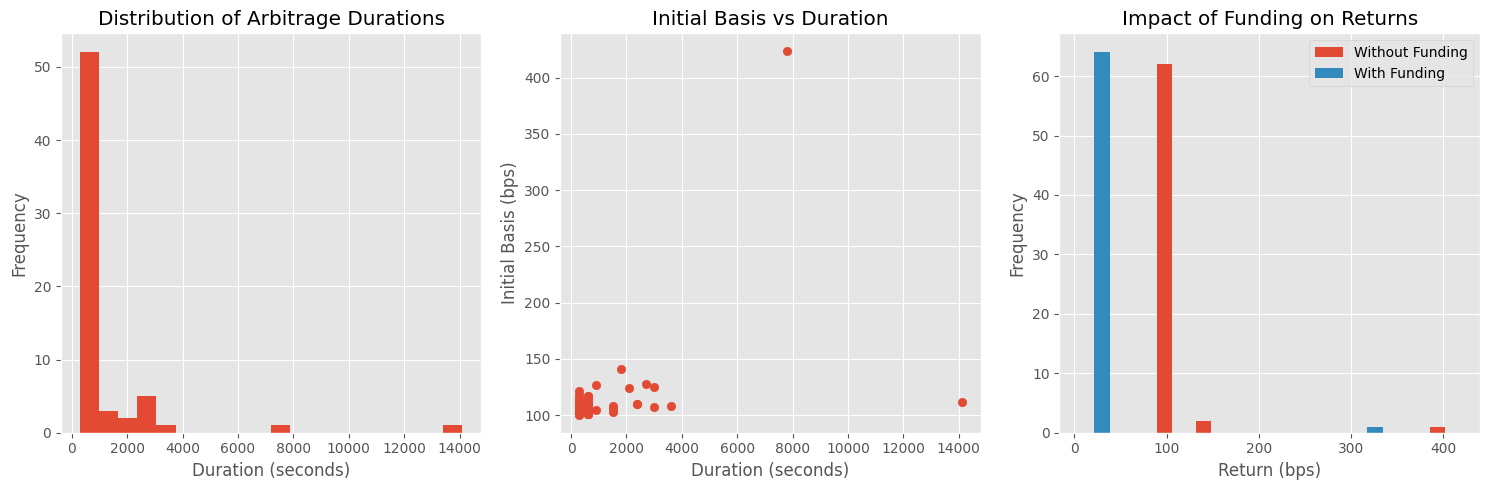

In [14]:
# Visualize the results
plt.figure(figsize=(15, 5))

# Plot 1: Distribution of opportunity durations
plt.subplot(131)
duration_details['duration'].dt.total_seconds().hist(bins=20)
plt.title('Distribution of Arbitrage Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

# Plot 2: Basis vs Duration
plt.subplot(132)
plt.scatter(duration_details['duration'].dt.total_seconds(), 
           duration_details['initial_basis'])
plt.title('Initial Basis vs Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Initial Basis (bps)')

# Plot 3: Returns with and without funding
plt.subplot(133)
plt.hist([funding_analysis['initial_basis'], 
          funding_analysis['total_return']], 
         label=['Without Funding', 'With Funding'])
plt.title('Impact of Funding on Returns')
plt.xlabel('Return (bps)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



### 1. What is the appropriate threshold for arbitrage?

The threshold analysis examines three fee tiers (Retail, VIP1, and VIP2) with different total transaction costs (including estimated slippage). Looking at the results:

>-  Retail traders need at least 24bps basis to break even (fees + slippage)
>- VIP1 traders need 20.5bps
>- VIP2 traders need 17bps

The data shows that even with the highest threshold (24bps for retail), there were 6,545 profitable opportunities with an average basis of 53.6bps. This suggests that a threshold of 100bps (which we used in the initial analysis) was quite conservative. The average profit potential ranges from 29-31bps across fee tiers, indicating that arbitrage opportunities are still profitable after accounting for transaction costs.

#### 2. Average duration until basis reverts and position can be closed?

The duration analysis reveals:

>- Average duration: 18.1 minutes
>- Median duration: 10 minutes
>- Maximum duration: 235 minutes (~4 hours)

The distribution plot shows that most opportunities are quite short-lived, with the majority resolving within 2000 seconds (about 33 minutes). The scatter plot of Initial Basis vs Duration shows no strong correlation between the size of the basis and how long it takes to revert, though there are some outliers with both high basis and longer durations.

#### 3. How does funding affect arbitrage return?

The funding impact analysis shows:

>- Average initial basis: 112.6bps
>- Average funding return: 0.038bps
>- Average total return (including funding): 12.66bps

The funding impact is relatively small because:

1. Most opportunities are short-lived (median 10 minutes)
2. Funding is paid every 8 hours at a low rate

Looking at the histogram comparing returns with and without funding, the distributions are very similar, confirming that funding has minimal impact on overall returns. This is mainly because the arbitrage opportunities in our dataset tend to resolve quickly before significant funding payments accumulate.

**Overall conclusions**:

1. Arbitrage opportunities are frequent but short-lived, requiring quick execution
2. The typical basis deviation is around 100-150 bps
3. Funding rates have minimal impact due to short holding periods
4. The strategy appears viable for traders who can execute quickly, especially those with lower trading fees
5. Risk management should account for the short window of opportunity and need for rapid position unwinding